<a href="https://colab.research.google.com/github/AmanPriyanshu/siamese-networks/blob/master/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plty
import numpy as np
import random
from sklearn.decomposition import PCA

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


Creating my own Callbacks

# PCAPlotter

In [0]:
class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plty, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plty.figure(figsize=(9, 4))
        self.ax1 = plty.subplot(1, 2, 1)
        self.ax2 = plty.subplot(1, 2, 2)
        plty.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        print("Starting..")
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

# Import MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [4]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


# Plots

In [0]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

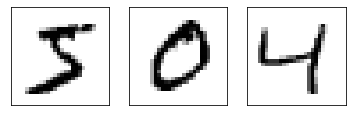

In [6]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Creating Triplets

In [0]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

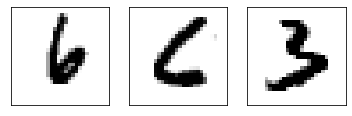

In [8]:
examples = create_batch(1)
plot_triplets(examples)

# Embedding

In [9]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [10]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.37105215 0.41630593 0.4289627  0.41813093 0.59721035 0.47662675
 0.54146576 0.6226392  0.57317567 0.61164397 0.63351464 0.49203074
 0.56652397 0.48581502 0.40654275 0.4550384  0.4984053  0.48824972
 0.48362646 0.3951364  0.50275606 0.4237929  0.41904092 0.49163505
 0.6061233  0.36666673 0.5602101  0.6627168  0.583355   0.43124935
 0.46309355 0.535637   0.5293012  0.3884884  0.56367254 0.4012228
 0.48883468 0.36673135 0.50756127 0.5813964  0.6178723  0.44936156
 0.5844454  0.5050642  0.4726976  0.43878716 0.43718633 0.41607782
 0.5107232  0.36875722 0.5560817  0.47146803 0.42980015 0.46648175
 0.51036716 0.5981286  0.4902892  0.57103944 0.49108815 0.44394433
 0.30122444 0.37166476 0.48350346 0.49694943]


# Siamese Network

In [11]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]                

# Own Loss - Triplet

In [0]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator

In [0]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Model

Starting..
Epoch 1/10
29/29 [==============================] - 27s 944ms/step - loss: 0.1637
Epoch 2/10
29/29 [==============================] - 27s 932ms/step - loss: 0.0751
Epoch 3/10
29/29 [==============================] - 27s 932ms/step - loss: 0.0563
Epoch 4/10
29/29 [==============================] - 27s 935ms/step - loss: 0.0492
Epoch 5/10
29/29 [==============================] - 27s 939ms/step - loss: 0.0445
Epoch 6/10
29/29 [==============================] - 27s 934ms/step - loss: 0.0403
Epoch 7/10
29/29 [==============================] - 27s 930ms/step - loss: 0.0359
Epoch 8/10
29/29 [==============================] - 27s 941ms/step - loss: 0.0338
Epoch 9/10
29/29 [==============================] - 27s 942ms/step - loss: 0.0310
Epoch 10/10
29/29 [==============================] - 27s 939ms/step - loss: 0.0295


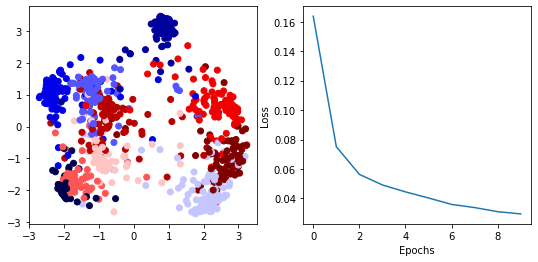

In [14]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)